# Introduction to Bayesian Last Layer

The purpose of this Jupyter Notebook is to provide a toy examples for BLL (not control related),
which is shown as Figure 1 in our paper.

Requires Tensorflow 2.0+ to run (where Keras is part of Tensorflow and not a stand-alone package)

In [1]:
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn import preprocessing

import tikzplotlib

Modifying Matplotlib for prettier graphics.

In [2]:
import matplotlib as mpl
from cycler import cycler
import matplotlib.ticker as plticker

mpl.rcParams.update({
    'lines.linewidth':2,
    'font.size': 16,
    'axes.labelsize': 'Large',
    'figure.figsize': (9, 6),
    'axes.grid': True,
    'lines.markersize': 10,
    'text.usetex': True,
    'axes.unicode_minus': False,
    'ps.fonttype': 42,
    'pdf.fonttype': 42
})

color = mpl.rcParams['axes.prop_cycle'].by_key()['color']

# Utility functions

``get_keras_model`` allows us to quickly obtain a (dense, feed-forward) Neural Network from keras/tensorflow with just a single line of code. 

Users must pass the parameters ``architecture`` and ``activation``,
where, e.g. ``architecture = [1,6,6,2]`` defines a NN with 1 input, two hidden layers with 6 neurons each and 2 outputs. The ``activation='relu'`` parameter sets a ReLu activation function for **ALL but the last layer**.

The method returns both two instances of ``tf.keras.Model``: One is used for training and predictions. The other one shares the same weights and computes the activations in the last layer. This one is used for the BLL uncertainty quantification.

In [3]:
def get_keras_model(architecture, activation='relu'):
    """Function to obtain a Keras model
    
    Model is defined by the parameter ``architecture`` which must be a list. 
    
    Example:
        
        architecture = [1, 5, 5, 1]
        
    Returns a NN with one input, two hidden layers (each with 5 neurons) and one output.
    
    All hidden layer (except for the output layer) have the same activation function.
    """
    inputs = keras.Input(shape=architecture[0], name='input')
    outputs = [inputs]
    
    for n_l in range(1, len(architecture)-1):
        outputs.append(keras.layers.Dense(architecture[n_l], 
                                 activation=activation,
                                 name='hidden_{}'.format(n_l))(outputs[n_l-1]))
        
    outputs.append(keras.layers.Dense(architecture[-1], 
                                      name='output')(outputs[-1]))
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs[-1]) 
    activation_model = tf.keras.Model(inputs=inputs, outputs=outputs[-2]) 
    return model, activation_model

# 2D example

We first create some data and plot the function we want to learn:

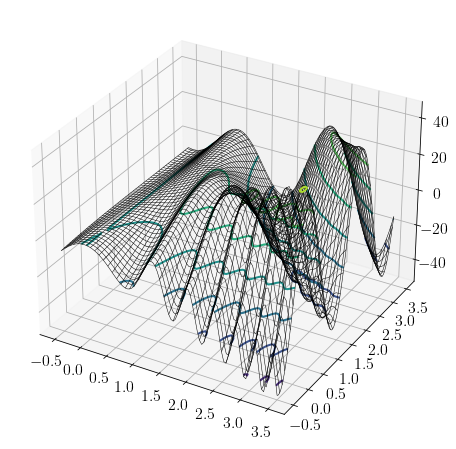

In [4]:
x = np.linspace(-0.5,3.5, 100)
X1, X2 = np.meshgrid(x,x)

y = (X1+3)**2*np.sin(X2*X1)- np.sin(np.pi*X1**2)*(X2-3)**2

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X1,X2,y, color='k', linewidth=0.5)
ax.contour(X1,X2,y)

X = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
Y = y.reshape(-1,1)

true = (X,Y)

For training, we only use a subset of this data, sampled from three distinct regions. 

In [5]:
np.random.seed(10)

# Center of the regions:
c1 = np.array([1,1]).reshape(1,-1)
c2 = np.array([2.5,2.5]).reshape(1,-1)
c3 = np.array([0, 3]).reshape(1,-1)

# Radius of the regions
r1 = 0.7
r2 = 0.3
r3 = 0.3

# Jitter of the regions 
j1 = 0.2
j2 = 0.2
j3 = 0.2

ind  = (np.linalg.norm(X-c1, axis=1) <= r1+j1*np.random.randn(X.shape[0]))
ind += (np.linalg.norm(X-c2, axis=1) <= r2+j2*np.random.randn(X.shape[0]))
ind += (np.linalg.norm(X-c3, axis=1) <= r3+j3*np.random.randn(X.shape[0]))

train = (X[ind], Y[ind])
val   = (X[~ind], Y[~ind])

In [6]:
m = train[0].shape[0]

print(f'Number of training samples m={m}.')

Number of training samples m=1529.


Plot the (input) location of the training samples:

Text(0, 0.5, 'y')

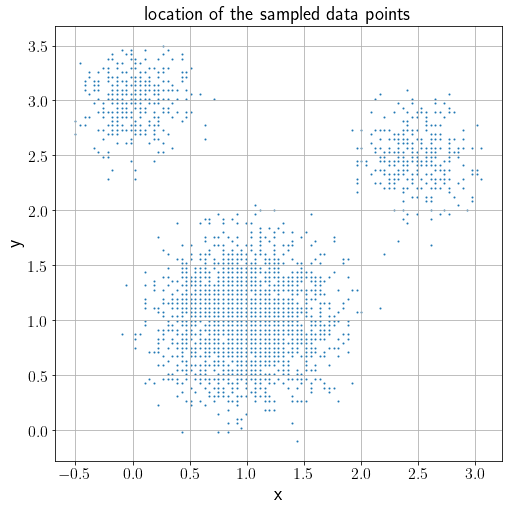

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(train[0][:,0],train[0][:,1], marker='x', s=0.5)
ax.set_title('location of the sampled data points')
ax.set_xlabel('x')
ax.set_ylabel('y')


## Neural Network with BLL

Define the neural network architecture and compile the model.

In [8]:
architecture = [2, 50, 50, 1]
tf.random.set_seed(123)

model, activation_model = get_keras_model(architecture, 'tanh')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MSE,
)

2021-12-01 13:12:45.463596: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 13:12:45.463760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model. Output is captured to be displayed more easily on Github.

In [9]:
%%capture
history = model.fit(
    train[0],
    train[1],
    epochs=3000,
    batch_size = 100
)

2021-12-01 13:12:45.534978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


With BLL we compute the following:

- Prediction with ``model``
- Activations of training data and test data with ``activation_model``
- Covariance of test data with **BLL**
- Standard deviation $\sigma$ and $\sigma^2$ for test points
- Error of prediction vs. true function for test points

For the plots, we do some post-precessing:

- Set saturation for error, $\sigma$ and $\sigma^2$ 
- Normalize $\sigma$ and $\sigma^2$.

In [10]:
sig_w = 1e0
sig_e = 1e0

Sigma_E = np.eye(train[1].shape[0])*1/sig_e**2          
Sigma_W = np.eye(architecture[-2])*1/sig_w**2

x_test = true[0]
y_test = true[1]
y_hat_nn = model.predict(x_test)
a_train = activation_model.predict(train[0])
a_hat = activation_model.predict(x_test)

cov = a_hat@np.linalg.inv(a_train.T@Sigma_E@a_train+Sigma_W)@a_hat.T
std2_nn_raw = np.diag(cov).reshape(X1.shape)
std_nn_raw = np.sqrt(std2_nn_raw)
err_nn_raw = np.abs(y_hat_nn-y_test).reshape(X1.shape)

std2_nn = copy.copy(std2_nn_raw)
std_nn = copy.copy(std_nn_raw)
err_nn = copy.copy(err_nn_raw)

cutoff = 80
std_nn[std_nn>np.percentile(std_nn,cutoff)] = np.percentile(std_nn,cutoff)
std2_nn[std2_nn>np.percentile(std2_nn,cutoff)] = np.percentile(std2_nn,cutoff)
err_nn[err_nn>np.percentile(err_nn,cutoff)] = np.percentile(err_nn,cutoff)

std2_nn_norm = std2_nn/std2_nn.max()
std_nn_norm = std_nn/std_nn.max()
err_nn_norm = err_nn/err_nn.max()

cm_std2_nn = cm.jet(std2_nn_norm)
cm_std_nn = cm.jet(std_nn_norm)
cm_err_nn = cm.jet(err_nn_norm)

Plot BLL prediction in 3-D:

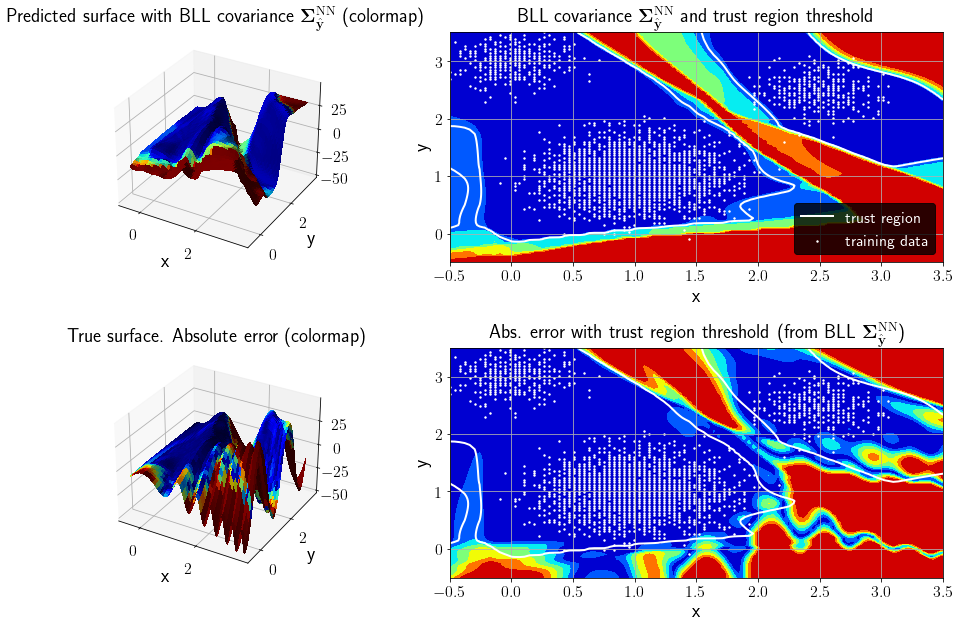

In [20]:
trust_threshold = 0.2

cov_str = '\mathbf{\Sigma}_{\hat \mathbf{y}}'
nn_str = '{\mathrm{\scriptsize NN}}'
gp_str = '{\mathrm{\scriptsize GP}}'

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title(f'Predicted surface with BLL covariance ${cov_str}^{nn_str}$ (colormap)', pad = 10)


ax.plot_surface(X1,X2,y_hat_nn.reshape(X1.shape), facecolors=cm_std2_nn, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 3, projection='3d', sharez=ax, sharex=ax, sharey=ax)
ax.plot_surface(X1,X2,y.reshape(X1.shape), facecolors=cm_err_nn, linewidth=0, antialiased=False)
ax.set_title('True surface. Absolute error (colormap)')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 2)
ax.contourf(X1,X2,std2_nn_norm, cmap='jet')
ax.contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax.plot([],[], color='w', label='trust region')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax.legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax.set_title(f'BLL covariance ${cov_str}^{nn_str}$ and trust region threshold', pad = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax.contourf(X1,X2,err_nn_norm, cmap='jet')
ax.contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax.set_title(f'Abs. error with trust region threshold (from BLL ${cov_str}^{nn_str}$)', pad=10)
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

## Gaussian Process

Train a GP with sklearn and compute the prediction and standard deviation.

In [12]:
sig_w_gp = 1e0

gpr = GaussianProcessRegressor(kernel=RBF(),normalize_y=True, alpha=1/(sig_w_gp**2)).fit(*train)

y_hat_gp, std_gp_raw = gpr.predict(true[0], return_std=True)

- Standard deviation $\sigma$ and $\sigma^2$ for test points
- Error of prediction vs. true function for test points

For the plots, we do some post-precessing:

- Set saturation for error, $\sigma$ and $\sigma^2$ 
- Normalize $\sigma$ and $\sigma^2$ (with same factor as NN)

In [13]:
err_gp_raw = np.abs(y_hat_gp-y_test).reshape(X1.shape)
std_gp_raw = std_gp_raw.reshape(X1.shape)
std2_gp_raw = std_gp_raw**2

std2_gp = copy.copy(std2_gp_raw)
std_gp = copy.copy(std_gp_raw)
err_gp = copy.copy(err_gp_raw)

cutoff = 80
std2_gp[std2_gp>np.percentile(std2_gp,cutoff)] = np.percentile(std2_gp,cutoff)
std_gp[std_gp>np.percentile(std_gp,cutoff)] = np.percentile(std_gp,cutoff)
err_gp[err_gp>np.percentile(err_gp,cutoff)] = np.percentile(err_gp,cutoff)

std2_gp_norm = std2_gp/std2_gp.max()
std_gp_norm = std_gp/std_gp.max()
# Normalize with same value as for NN
err_gp_norm = err_gp/err_nn.max()

cm_std2_gp = cm.jet(std2_gp_norm)
cm_std_gp = cm.jet(std_gp_norm)
cm_err_gp = cm.jet(err_gp_norm)

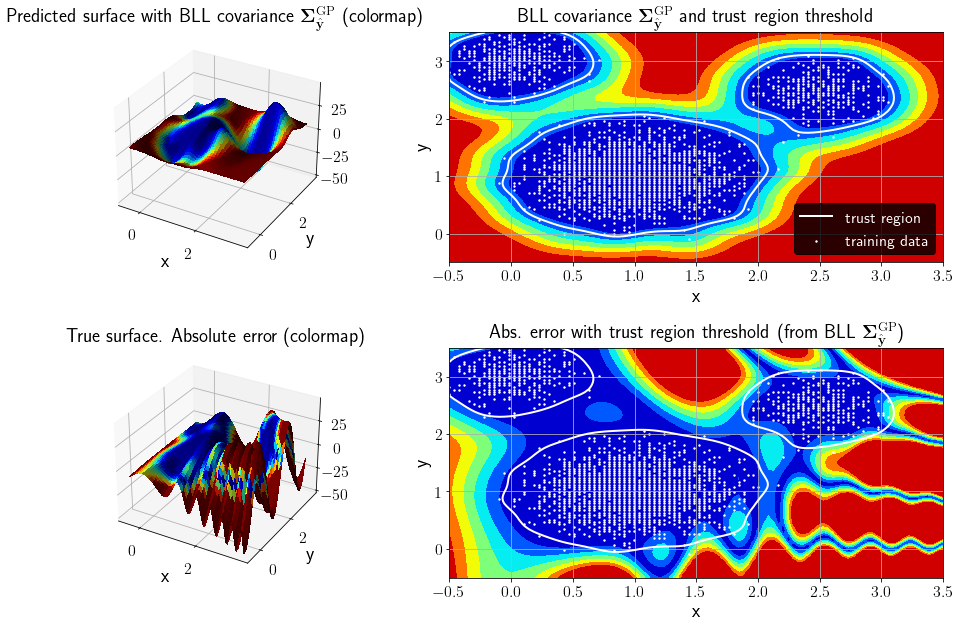

In [22]:
trust_threshold = 0.2

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title(f'Predicted surface with BLL covariance ${cov_str}^{gp_str}$ (colormap)', pad = 10)
ax.plot_surface(X1,X2,y_hat_gp.reshape(X1.shape), facecolors=cm_std2_gp,linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 3, projection='3d', sharez=ax, sharex=ax, sharey=ax)
ax.plot_surface(X1,X2,y.reshape(X1.shape), facecolors=cm_err_gp, linewidth=0, antialiased=False)
ax.set_title('True surface. Absolute error (colormap)')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 2)
ax.contourf(X1,X2,std2_gp_norm, cmap='jet')
ax.contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax.plot([],[], color='w', label='trust region')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax.legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax.set_title(f'BLL covariance ${cov_str}^{gp_str}$ and trust region threshold', pad = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax.contourf(X1,X2,err_gp_norm, cmap='jet')
ax.contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax.set_title(f'Abs. error with trust region threshold (from BLL ${cov_str}^{gp_str}$)', pad=10)
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

## Comparison of GP and BLL 

The following plot is created for the publication.

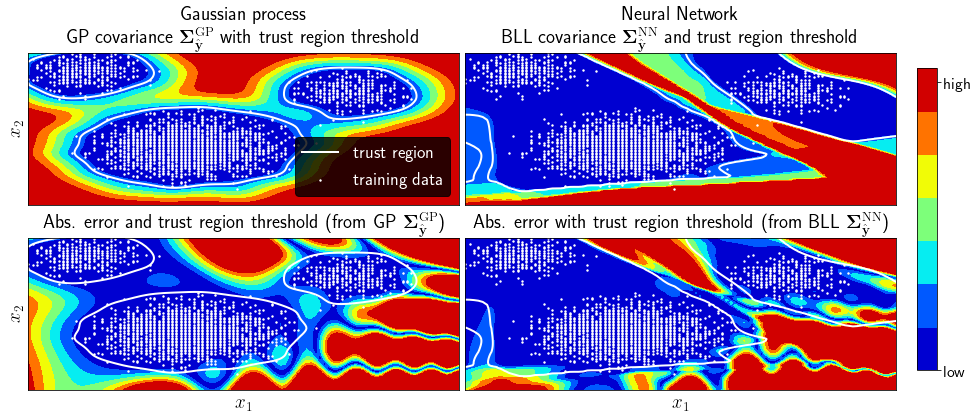

In [15]:
trust_threshold = 0.2

fig, ax = plt.subplots(2,2, figsize=(14,6), sharex=True, sharey=True)

cov_str = '\mathbf{\Sigma}_{\hat \mathbf{y}}'
nn_str = '{\mathrm{\scriptsize NN}}'
gp_str = '{\mathrm{\scriptsize GP}}'

ax[0,0].contourf(X1,X2,std2_gp_norm, cmap='jet')
ax[0,0].contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax[0,0].plot([],[], color='w', label='trust region')
ax[0,0].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax[0,0].legend(fontsize=18)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax[0,0].set_title(f'Gaussian process \n GP covariance ${cov_str}^{gp_str}$ with trust region threshold', pad=10)
ax[0,0].set_ylabel('$x_2$')

ax[1,0].contourf(X1,X2,err_gp_norm, cmap='jet')
ax[1,0].contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax[1,0].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax[1,0].set_title(f'Abs. error and trust region threshold (from GP ${cov_str}^{gp_str}$)', pad=10)
ax[1,0].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')


ax[0,1].contourf(X1,X2,std2_nn_norm, cmap='jet')
ax[0,1].contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax[0,1].plot([],[], color='w', label='trust region')
ax[0,1].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')

ax[0,1].set_title(f'Neural Network \n BLL covariance ${cov_str}^{nn_str}$ and trust region threshold', pad = 10)

cim = ax[1,1].contourf(X1,X2,err_nn_norm, cmap='jet')
ax[1,1].contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax[1,1].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax[1,1].set_title(f'Abs. error with trust region threshold (from BLL ${cov_str}^{nn_str}$)', pad=10)
ax[1,1].set_xlabel('$x_1$')

fig.tight_layout(pad=0.2)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cim, cax=cbar_ax, ticks=[np.max(err_nn_norm), np.min(err_nn_norm)])
cbar.ax.set_yticklabels(['high', 'low'])  # vertically oriented colorbar

ax[0,0].xaxis.set_ticks([])
ax[0,0].yaxis.set_ticks([])

# Export plot:
#fig.savefig('./figures/BLL_GP_2D_trust_region.pdf',format='pdf',pad_inches=0)

### Additional metrics

In [16]:
trust_region_ind_gp = (std2_gp_norm<trust_threshold).reshape(-1,1)

tot_err_gp_tr = np.mean(err_gp_raw.reshape(-1,1)[trust_region_ind_gp])
tot_err_gp_full = np.mean(err_gp_raw)
tot_trust_region_gp = np.sum(trust_region_ind_gp)/std_gp_norm.size

print('Gaussian process:')
print(f'Total trust region size: {100*tot_trust_region_gp:.2f}% with a mean error of {tot_err_gp_tr:.2f}')
print(f'Mean error of entire space:{tot_err_gp_full:.2f}')

Gaussian process:
Total trust region size: 36.45% with a mean error of 0.76
Mean error of entire space:8.10


In [17]:
trust_region_ind = (std2_nn_norm<trust_threshold).reshape(-1,1)

tot_err_nn_tr = np.mean(err_nn_raw.reshape(-1,1)[trust_region_ind])
tot_err_nn_full = np.mean(err_nn_raw)
tot_trust_region_nn = np.sum(trust_region_ind)/std_nn_norm.size

print('Neural Network:')
print(f'Total trust region size: {100*tot_trust_region_nn:.2f}% with a mean error of {tot_err_nn_tr:.2f}')
print(f'Mean error of entire space:{tot_err_nn_full:.2f}')

Neural Network:
Total trust region size: 58.79% with a mean error of 0.86
Mean error of entire space:7.41
